In [1]:
!python -V

Python 3.12.0


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

import pickle

In [4]:
# ! pip install pyarrow

In [5]:
# !pip install mlflow

In [7]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")  ## using sqlite backend
mlflow.set_experiment("my-taxi-experiment")

2024/05/27 13:18:18 INFO mlflow.tracking.fluent: Experiment with name 'my-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/personal_project/REPO-SAA23/MLOps-Zoomcamp2024/02-experiment-tracking/mlruns/2', creation_time=1716790698779, experiment_id='2', last_update_time=1716790698779, lifecycle_stage='active', name='my-taxi-experiment', tags={}>

### Loading Data and  Preprocessing Pipeline

In [8]:
def read_dataframe(filename):
    """
    Pipeline for loading dataset and preprocessing
    """
    df = pd.read_parquet(filename)
    
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df['duration'].apply(lambda dur: dur.total_seconds()/60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [9]:
## train and validation set
df_train = read_dataframe('./dataset/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./dataset/green_tripdata_2021-02.parquet')

In [10]:
len(df_train), len(df_val)

(73908, 61921)

In [11]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [12]:
df_val.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.0,...,0.5,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.5,...,0.5,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.5,...,0.5,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.0,...,0.5,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.5,...,0.5,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667


#### Explore Training Set

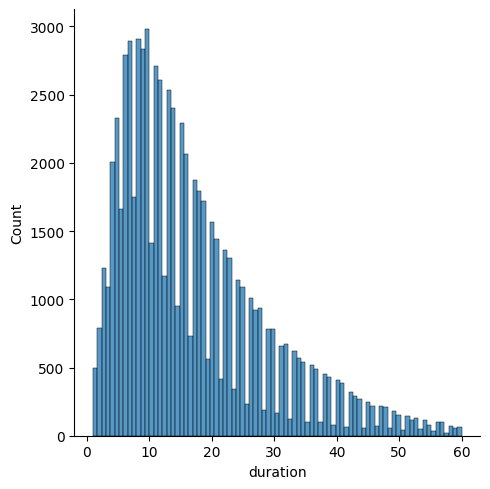

In [13]:
sns.displot(df_train.duration)
plt.show()

In [14]:
df_train.duration.describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: duration, dtype: float64

In [15]:
df_train.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

### Training Pipeline

In [16]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [17]:
# categorical = ['PULocationID','DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [18]:
target = 'duration'
y_train = df_train[target].values 
y_val = df_val[target].values 

#### Prediction on Training Set

In [19]:
## model building (Linear Regression)

lr = LinearRegression()
lr.fit(X_train, y_train)  ### model training

y_pred = lr.predict(X_train)   ### prediction inference

## model evaluation
mean_squared_error(y_train, y_pred, squared=False)  ### root mean square

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


5.699564118198982

#### Prediction on Validation Set

In [20]:
## model building (Linear Regression)

lr = LinearRegression()
lr.fit(X_train, y_train)  ### model training

y_pred = lr.predict(X_val)   ### prediction inference

## model evaluation
mean_squared_error(y_val, y_pred, squared=False)  ### root mean square

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715212021978

### Save Linear Regression models

In [22]:
with open('./models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv, lr), f_out)

#### Additional: Try Out Other Models

In [25]:
with mlflow.start_run():
    mlflow.set_tag("developer","saadi")
    mlflow.log_param("train-data-path","./dataset/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./dataset/green_tripdata_2021-02.parquet")
    
    alpha = 0.01

    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)  ### model training
    
    y_pred = lr.predict(X_val)   ### prediction inference
    
    ## model evaluation
    rmse = mean_squared_error(y_val, y_pred, squared=False)  ### root mean square
    mlflow.log_metric("rmse", rmse)

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
## model building (Ridge with alpha 0.001)

lr = Ridge(alpha=0.001)
lr.fit(X_train, y_train)  ### model training

y_pred = lr.predict(X_val)   ### prediction inference

## model evaluation
mean_squared_error(y_val, y_pred, squared=False)  ### root mean square

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.5215150461613325

In [28]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [29]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [30]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [31]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                   | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:42:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.95901                                                                   
[1]	validation-rmse:9.96226                                                                    
[2]	validation-rmse:9.17766                                                                    
[3]	validation-rmse:8.56600                                                                    
[4]	validation-rmse:8.09430                                                                    
[5]	validation-rmse:7.73364                                                                    
[6]	validation-rmse:7.45818                                                                    
[7]	validation-rmse:7.24894                                                                    
[8]	validation-rmse:7.08991                                                                    
[9]	validation-rmse:6.96799                                                                    
[10]	validation-rmse:6.87459            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.80549                                                                   
[1]	validation-rmse:9.72059                                                                    
[2]	validation-rmse:8.89343                                                                    
[3]	validation-rmse:8.27125                                                                    
[4]	validation-rmse:7.81051                                                                    
[5]	validation-rmse:7.46977                                                                    
[6]	validation-rmse:7.21914                                                                    
[7]	validation-rmse:7.03709                                                                    
[8]	validation-rmse:6.90303                                                                    
[9]	validation-rmse:6.80280                                                                    
[10]	validation-rmse:6.72811            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.81760                                                                    
[1]	validation-rmse:6.63350                                                                    
[2]	validation-rmse:6.61218                                                                    
[3]	validation-rmse:6.60037                                                                    
[4]	validation-rmse:6.58802                                                                    
[5]	validation-rmse:6.57804                                                                    
[6]	validation-rmse:6.56777                                                                    
[7]	validation-rmse:6.56304                                                                    
[8]	validation-rmse:6.55521                                                                    
[9]	validation-rmse:6.54938                                                                    
[10]	validation-rmse:6.54447            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:54:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.02612                                                                    
[1]	validation-rmse:6.69150                                                                    
[2]	validation-rmse:6.65975                                                                    
[3]	validation-rmse:6.65098                                                                    
[4]	validation-rmse:6.64623                                                                    
[5]	validation-rmse:6.63458                                                                    
[6]	validation-rmse:6.62715                                                                    
[7]	validation-rmse:6.61703                                                                    
[8]	validation-rmse:6.60985                                                                    
[9]	validation-rmse:6.60757                                                                    
[10]	validation-rmse:6.60310            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:54:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.73087                                                                   
[1]	validation-rmse:11.28550                                                                   
[2]	validation-rmse:10.87449                                                                   
[3]	validation-rmse:10.49595                                                                   
[4]	validation-rmse:10.14759                                                                   
[5]	validation-rmse:9.82749                                                                    
[6]	validation-rmse:9.53401                                                                    
[7]	validation-rmse:9.26518                                                                    
[8]	validation-rmse:9.01899                                                                    
[9]	validation-rmse:8.79395                                                                    
[10]	validation-rmse:8.58879            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:57:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.38014                                                                   
[1]	validation-rmse:10.65691                                                                   
[2]	validation-rmse:10.03163                                                                   
[3]	validation-rmse:9.49308                                                                    
[4]	validation-rmse:9.03109                                                                    
[5]	validation-rmse:8.63714                                                                    
[6]	validation-rmse:8.30031                                                                    
[7]	validation-rmse:8.01567                                                                    
[8]	validation-rmse:7.77429                                                                    
[9]	validation-rmse:7.57155                                                                    
[10]	validation-rmse:7.40032            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:01:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.86074                                                                    
[1]	validation-rmse:6.68883                                                                    
[2]	validation-rmse:6.65602                                                                    
[3]	validation-rmse:6.64357                                                                    
[4]	validation-rmse:6.63667                                                                    
[5]	validation-rmse:6.62765                                                                    
[6]	validation-rmse:6.62105                                                                    
[7]	validation-rmse:6.61476                                                                    
[8]	validation-rmse:6.61194                                                                    
[9]	validation-rmse:6.60911                                                                    
[10]	validation-rmse:6.60633            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:01:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.68769                                                                   
[1]	validation-rmse:11.20769                                                                   
[2]	validation-rmse:10.76942                                                                   
[3]	validation-rmse:10.37102                                                                   
[4]	validation-rmse:10.00782                                                                   
[5]	validation-rmse:9.67845                                                                    
[6]	validation-rmse:9.38009                                                                    
[7]	validation-rmse:9.11082                                                                    
[8]	validation-rmse:8.86787                                                                    
[9]	validation-rmse:8.64823                                                                    
[10]	validation-rmse:8.45054            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:02:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.32820                                                                   
[1]	validation-rmse:10.57340                                                                   
[2]	validation-rmse:9.93385                                                                    
[3]	validation-rmse:9.39382                                                                    
[4]	validation-rmse:8.94041                                                                    
[5]	validation-rmse:8.56158                                                                    
[6]	validation-rmse:8.24687                                                                    
[7]	validation-rmse:7.98623                                                                    
[8]	validation-rmse:7.77030                                                                    
[9]	validation-rmse:7.59226                                                                    
[10]	validation-rmse:7.44579            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:05:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.65810                                                                   
[1]	validation-rmse:11.15155                                                                   
[2]	validation-rmse:10.69063                                                                   
[3]	validation-rmse:10.27136                                                                   
[4]	validation-rmse:9.89115                                                                    
[5]	validation-rmse:9.54606                                                                    
[6]	validation-rmse:9.23347                                                                    
[7]	validation-rmse:8.95267                                                                    
[8]	validation-rmse:8.69865                                                                    
[9]	validation-rmse:8.46920                                                                    
[10]	validation-rmse:8.26385            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:08:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.81113                                                                    
[1]	validation-rmse:6.56511                                                                    
[2]	validation-rmse:6.53395                                                                    
[3]	validation-rmse:6.51894                                                                    
[4]	validation-rmse:6.50820                                                                    
[5]	validation-rmse:6.49990                                                                    
[6]	validation-rmse:6.49123                                                                    
[7]	validation-rmse:6.48670                                                                    
[8]	validation-rmse:6.47840                                                                    
[9]	validation-rmse:6.47356                                                                    
[10]	validation-rmse:6.46582            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:09:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.96084                                                                   
[1]	validation-rmse:9.96153                                                                    
[2]	validation-rmse:9.17261                                                                    
[3]	validation-rmse:8.55592                                                                    
[4]	validation-rmse:8.07914                                                                    
[5]	validation-rmse:7.71098                                                                    
[6]	validation-rmse:7.43145                                                                    
[7]	validation-rmse:7.21770                                                                    
[8]	validation-rmse:7.05592                                                                    
[9]	validation-rmse:6.93241                                                                    
[10]	validation-rmse:6.83638            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:11:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.98521                                                                    
[1]	validation-rmse:8.59525                                                                    
[2]	validation-rmse:7.75855                                                                    
[3]	validation-rmse:7.26813                                                                    
[4]	validation-rmse:6.98637                                                                    
[5]	validation-rmse:6.81843                                                                    
[6]	validation-rmse:6.71925                                                                    
[7]	validation-rmse:6.65432                                                                    
[8]	validation-rmse:6.61414                                                                    
[9]	validation-rmse:6.58701                                                                    
[10]	validation-rmse:6.56683            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:12:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.07096                                                                   
[1]	validation-rmse:8.69431                                                                    
[2]	validation-rmse:7.83871                                                                    
[3]	validation-rmse:7.32204                                                                    
[4]	validation-rmse:7.01434                                                                    
[5]	validation-rmse:6.82838                                                                    
[6]	validation-rmse:6.71221                                                                    
[7]	validation-rmse:6.63988                                                                    
[8]	validation-rmse:6.59309                                                                    
[9]	validation-rmse:6.56014                                                                    
[10]	validation-rmse:6.53873            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:14:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.90823                                                                    
[1]	validation-rmse:8.51384                                                                    
[2]	validation-rmse:7.69588                                                                    
[3]	validation-rmse:7.22970                                                                    
[4]	validation-rmse:6.96470                                                                    
[5]	validation-rmse:6.81014                                                                    
[6]	validation-rmse:6.72152                                                                    
[7]	validation-rmse:6.66623                                                                    
[8]	validation-rmse:6.61721                                                                    
[9]	validation-rmse:6.59370                                                                    
[10]	validation-rmse:6.57645            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:15:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.74791                                                                   
[1]	validation-rmse:9.63597                                                                    
[2]	validation-rmse:8.80457                                                                    
[3]	validation-rmse:8.19137                                                                    
[4]	validation-rmse:7.74420                                                                    
[5]	validation-rmse:7.41927                                                                    
[6]	validation-rmse:7.18683                                                                    
[7]	validation-rmse:7.01910                                                                    
[8]	validation-rmse:6.89712                                                                    
[9]	validation-rmse:6.80853                                                                    
[10]	validation-rmse:6.74341            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:17:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.65405                                                                   
[1]	validation-rmse:11.14413                                                                   
[2]	validation-rmse:10.67951                                                                   
[3]	validation-rmse:10.25702                                                                   
[4]	validation-rmse:9.87346                                                                    
[5]	validation-rmse:9.52608                                                                    
[6]	validation-rmse:9.21109                                                                    
[7]	validation-rmse:8.92741                                                                    
[8]	validation-rmse:8.67192                                                                    
[9]	validation-rmse:8.44018                                                                    
[10]	validation-rmse:8.23324            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:29:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.60204                                                                   
[1]	validation-rmse:11.05105                                                                   
[2]	validation-rmse:10.55443                                                                   
[3]	validation-rmse:10.10936                                                                   
[4]	validation-rmse:9.71006                                                                    
[5]	validation-rmse:9.35317                                                                    
[6]	validation-rmse:9.03470                                                                    
[7]	validation-rmse:8.75158                                                                    
[8]	validation-rmse:8.49937                                                                    
[9]	validation-rmse:8.27539                                                                    
[10]	validation-rmse:8.07717            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:31:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.70976                                                                    
[1]	validation-rmse:8.30678                                                                    
[2]	validation-rmse:7.55993                                                                    
[3]	validation-rmse:7.16785                                                                    
[4]	validation-rmse:6.96572                                                                    
[5]	validation-rmse:6.85271                                                                    
[6]	validation-rmse:6.78734                                                                    
[7]	validation-rmse:6.74994                                                                    
[8]	validation-rmse:6.72746                                                                    
[9]	validation-rmse:6.71238                                                                    
[10]	validation-rmse:6.70091            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:33:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.69605                                                                    
[1]	validation-rmse:7.34642                                                                    
[2]	validation-rmse:6.86871                                                                    
[3]	validation-rmse:6.68953                                                                    
[4]	validation-rmse:6.61053                                                                    
[5]	validation-rmse:6.56533                                                                    
[6]	validation-rmse:6.54288                                                                    
[7]	validation-rmse:6.53398                                                                    
[8]	validation-rmse:6.52633                                                                    
[9]	validation-rmse:6.52133                                                                    
[10]	validation-rmse:6.51502            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80487                                                                   
[1]	validation-rmse:11.42346                                                                   
[2]	validation-rmse:11.06741                                                                   
[3]	validation-rmse:10.73587                                                                   
[4]	validation-rmse:10.42435                                                                   
[5]	validation-rmse:10.13910                                                                   
[6]	validation-rmse:9.86821                                                                    
[7]	validation-rmse:9.62172                                                                    
[8]	validation-rmse:9.38714                                                                    
[9]	validation-rmse:9.17332                                                                    
[10]	validation-rmse:8.97293            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.45646                                                                   
[1]	validation-rmse:10.78962                                                                   
[2]	validation-rmse:10.20591                                                                   
[3]	validation-rmse:9.69374                                                                    
[4]	validation-rmse:9.24724                                                                    
[5]	validation-rmse:8.85952                                                                    
[6]	validation-rmse:8.52368                                                                    
[7]	validation-rmse:8.23129                                                                    
[8]	validation-rmse:7.98073                                                                    
[9]	validation-rmse:7.76447                                                                    
[10]	validation-rmse:7.57927            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.42742                                                                   
[1]	validation-rmse:10.74523                                                                   
[2]	validation-rmse:10.15064                                                                   
[3]	validation-rmse:9.63793                                                                    
[4]	validation-rmse:9.18837                                                                    
[5]	validation-rmse:8.80497                                                                    
[6]	validation-rmse:8.47636                                                                    
[7]	validation-rmse:8.19250                                                                    
[8]	validation-rmse:7.95200                                                                    
[9]	validation-rmse:7.74865                                                                    
[10]	validation-rmse:7.57151            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:47:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.26976                                                                   
[1]	validation-rmse:10.47234                                                                   
[2]	validation-rmse:9.80208                                                                    
[3]	validation-rmse:9.24185                                                                    
[4]	validation-rmse:8.77767                                                                    
[5]	validation-rmse:8.39224                                                                    
[6]	validation-rmse:8.07664                                                                    
[7]	validation-rmse:7.81753                                                                    
[8]	validation-rmse:7.60329                                                                    
[9]	validation-rmse:7.43045                                                                    
[10]	validation-rmse:7.28743            

C:\Users\achma\Envs\scraping312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:55:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.52178                                                                   
[1]	validation-rmse:10.90491                                                                   
[2]	validation-rmse:10.35597                                                                   
[3]	validation-rmse:9.86911                                                                    
[4]	validation-rmse:9.43881                                                                    
[5]	validation-rmse:9.05979                                                                    
[6]	validation-rmse:8.72684                                                                    
[7]	validation-rmse:8.43303                                                                    
[8]	validation-rmse:8.17743                                                                    
[9]	validation-rmse:7.95299                                                                    
[10]	validation-rmse:7.75695            

KeyboardInterrupt: 

In [ ]:
from math import exp

### Autolog

In [33]:
# XGBOOST

# the best parameter from hyperopt
params = {
    'max_depth': 86,
    'learning_rate': 0.09246520461763111,
    'reg_alpha': 0.0814781928580627,
    'reg_lambda': 0.049407724522028774,
    'min_child_weight': 1.052977029116394,
    'objective': 'reg:linear',
    'seed': 42
}

# with mlflow.start_run():
#     mlflow.set_tag()
#     mlflow.log_param()

mlflow.xgboost.autolog()
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2024/05/27 15:32:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '09ba2620bef541f7981bf8eab60e5561', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2024/05/27 15:32:15 WARNING mlflow.xgboost: Failed to log dataset information to MLflow Tracking. Reason: Unable to allocate 3.64 GiB for an array with shape (977137668,) and data type float32
C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.45646
[1]	validation-rmse:10.78962
[2]	validation-rmse:10.20591
[3]	validation-rmse:9.69374
[4]	validation-rmse:9.24724
[5]	validation-rmse:8.85952
[6]	validation-rmse:8.52368
[7]	validation-rmse:8.23129
[8]	validation-rmse:7.98073
[9]	validation-rmse:7.76447
[10]	validation-rmse:7.57927
[11]	validation-rmse:7.41996
[12]	validation-rmse:7.28393
[13]	validation-rmse:7.16818
[14]	validation-rmse:7.06863
[15]	validation-rmse:6.98458
[16]	validation-rmse:6.91224
[17]	validation-rmse:6.84972
[18]	validation-rmse:6.79529
[19]	validation-rmse:6.74953
[20]	validation-rmse:6.70942
[21]	validation-rmse:6.67537
[22]	validation-rmse:6.64576
[23]	validation-rmse:6.62052
[24]	validation-rmse:6.59765
[25]	validation-rmse:6.57735
[26]	validation-rmse:6.56058
[27]	validation-rmse:6.54604
[28]	validation-rmse:6.53329
[29]	validation-rmse:6.52058
[30]	validation-rmse:6.50973
[31]	validation-rmse:6.50047
[32]	validation-rmse:6.49251
[33]	validation-rmse:6.48428
[34]	validation-rmse:

2024/05/27 15:42:19 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/27 15:42:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\achma\Envs\scraping312\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


In [32]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

2024/05/27 14:58:48 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


FileNotFoundError: [WinError 2] The system cannot find the file specified